# League of legend Winner team predict to Using Riot API

2019 데이터분석 개인 프로젝트 리메이크

리그 오브 레전드 경기 기록을 수집하고, 가공하여 승률에 영향을 주는 요인 분석과 실시간 스코어 변동에 따른 승률 예측 프로젝트

A project to collect league-of-legend game records to analyze the factors that affect victory and to predict winning rates based on real-time score fluctuations.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lol-classic-rank-game-datakrtop-3-tier/lose_team_stats.csv
/kaggle/input/lol-classic-rank-game-datakrtop-3-tier/match_winner_data.pkl
/kaggle/input/lol-classic-rank-game-datakrtop-3-tier/match_ver1.pkl
/kaggle/input/lol-classic-rank-game-datakrtop-3-tier/matchpre.pkl
/kaggle/input/lol-classic-rank-game-datakrtop-3-tier/win_team_stats.csv
/kaggle/input/lol-classic-rank-game-datakrtop-3-tier/match_lose_data.pkl
/kaggle/input/lol-classic-rank-game-datakrtop-3-tier/stats.csv
/kaggle/input/lol-classic-rank-game-datakrtop-3-tier/lol_version_Date.csv


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from tqdm import tqdm_notebook # 오래 걸리는 작업 진행확인용
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
pd.options.display.max_rows = 100

In [4]:
match = pd.read_pickle("/kaggle/input/lol-classic-rank-game-datakrtop-3-tier/matchpre.pkl")

win_team_stat = pd.read_csv("/kaggle/input/lol-classic-rank-game-datakrtop-3-tier/win_team_stats.csv")

lose_team_stat = pd.read_csv("/kaggle/input/lol-classic-rank-game-datakrtop-3-tier/lose_team_stats.csv")

win_team = pd.read_pickle("/kaggle/input/lol-classic-rank-game-datakrtop-3-tier/match_winner_data.pkl")

lose_team = pd.read_pickle("/kaggle/input/lol-classic-rank-game-datakrtop-3-tier/match_lose_data.pkl")

date = pd.read_csv("/kaggle/input/lol-classic-rank-game-datakrtop-3-tier/lol_version_Date.csv")

In [5]:
"""
팀 스탯 row 와 팀 기록 row 일치시키기
"""
gameId = win_team_stat["gameId"]
match = pd.merge(gameId,match,how="inner",on="gameId")
win_team = pd.merge(gameId,win_team,how="inner",on="gameId")
lose_team = pd.merge(gameId,lose_team,how="inner",on="gameId")

"""
duplicated() 함수는 리스트에 대한 중복검사를 지원하지 않으므로 리스트 칼럼 삭제
"""
match.drop("participants",axis=1,inplace=True)

win_team.drop("bans",axis=1,inplace=True)

lose_team.drop("bans",axis=1,inplace=True)

match = match.drop_duplicates()
win_team = win_team.drop_duplicates()
lose_team = lose_team.drop_duplicates()

win_team_stat = win_team_stat.drop_duplicates()
lose_team_stat = lose_team_stat.drop_duplicates()

"""
win_team, lose_team으로 나누어 모든 테이블 병합
"""
win_team = pd.merge(match,win_team,how="left",on="gameId")
win_team = pd.merge(win_team,win_team_stat,how="left",on="gameId")

lose_team = pd.merge(match,lose_team,how="left",on="gameId")
lose_team = pd.merge(lose_team,lose_team_stat,how="left",on="gameId")

del match
gc.collect()

"""
팀 데이터셋을 전체 데이터로 병합하기 전에 칼럼명 일치시키기
"""
win_team.columns = win_team.columns.str.replace("win_","")

lose_team.columns = lose_team.columns.str.replace("lose_","")

"""
전체 게임 정보 gamedata 테이블 생성
"""
gamedata = pd.concat([win_team,lose_team])
gamedata = gamedata.reset_index()
gamedata.drop("index",axis=1,inplace=True)
gamedata = gamedata.astype({"gameVersion":int})
gamedata = pd.merge(gamedata,date,how="inner",on="gameVersion")

del win_team
del lose_team
gc.collect()

"""
카테고리형 데이터(True,False) Label encoding / 분석에 용이하도록 가공
"""
bool_mapping = {True:1,False:0}
bool_col = gamedata.select_dtypes('bool').columns.tolist()

for col in bool_col:
    gamedata[col] = gamedata[col].map(bool_mapping)
    
win_mapping = {"Win":1,"Fail":0}
gamedata["win"] = gamedata["win"].map(win_mapping)

gamedata["date"] = pd.to_datetime(gamedata["date"])
gamedata["gameId"] = gamedata.astype({"gameId":object})

In [6]:
gamedata

,gameId,gameDuration,gameVersion,teamId,win,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,visionScore2,visionScore3,visionScore4,visionScore5,totalTimeCrowdControlDealt1,totalTimeCrowdControlDealt2,totalTimeCrowdControlDealt3,totalTimeCrowdControlDealt4,totalTimeCrowdControlDealt5,date
0,4.24726e+09,1323.0,1063144405,200,1,0,1,1,0,1,...,16.0,23.0,17.0,36.0,183.0,92.0,231.0,54.0,281.0,2020-03-25
1,4.24716e+09,1317.0,1063144405,100,1,0,0,0,0,1,...,27.0,46.0,16.0,22.0,33.0,291.0,31.0,235.0,407.0,2020-03-25
2,4.2558e+09,1244.0,1063144405,200,1,1,1,1,0,1,...,35.0,25.0,15.0,21.0,178.0,82.0,371.0,140.0,122.0,2020-03-25
3,4.25576e+09,962.0,1063144405,200,1,0,1,0,0,1,...,25.0,17.0,9.0,19.0,134.0,61.0,332.0,274.0,163.0,2020-03-25
4,4.25566e+09,1632.0,1063144405,200,1,1,1,1,1,0,...,38.0,30.0,18.0,26.0,69.0,503.0,562.0,79.0,69.0,2020-03-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180923,3.49913e+09,1179.0,912577563,200,0,0,0,0,0,0,...,21.0,22.0,18.0,10.0,67.0,155.0,56.0,553.0,124.0,2018-12-15
180924,3.50385e+09,1684.0,912577563,100,0,0,0,0,0,1,...,30.0,14.0,19.0,27.0,127.0,1454.0,540.0,48.0,555.0,2018-12-15
180925,3.49546e+09,1464.0,912577563,100,0,1,1,0,0,0,...,51.0,17.0,14.0,21.0,622.0,80.0,536.0,0.0,112.0,2018-12-15
180926,3.49913e+09,1694.0,912577563,200,0,1,1,0,0,1,...,23.0,22.0,72.0,25.0,296.0,285.0,822.0,139.0,657.0,2018-12-15


# 4. Feature Engineering / 특성 공학

In [7]:
#예측에 필요없는 칼럼 드랍(승패예측에 영향을 끼치지 못함)
gamedata.drop(["gameVersion","vilemawKills","dominionVictoryScore","date"],axis=1,inplace=True)

In [8]:
pd.set_option('display.float_format', '{:.5f}'.format) # 항상 float 형식으로

In [9]:
#승패에 영향이 가는 상관계수 분석
gamedata.corr()["win"].sort_values()

deaths3                        -0.40363
deaths2                        -0.40341
deaths4                        -0.40273
deaths1                        -0.40120
deaths5                        -0.39988
gameDuration                    0.00000
teamId                          0.01249
totalTimeCrowdControlDealt3     0.04594
totalTimeCrowdControlDealt2     0.04824
totalTimeCrowdControlDealt1     0.04880
totalTimeCrowdControlDealt5     0.04882
totalTimeCrowdControlDealt4     0.04920
visionScore1                    0.08514
visionScore5                    0.08830
visionScore4                    0.08980
visionScore2                    0.09021
visionScore3                    0.09344
totalDamageDealtToChampions5    0.13442
totalDamageDealtToChampions4    0.13801
totalDamageDealtToChampions3    0.13868
totalDamageDealtToChampions2    0.13910
totalDamageDealtToChampions1    0.13965
firstBlood                      0.21697
goldEarned5                     0.24347
goldEarned4                     0.24478


In [10]:
gamedata.head()

,gameId,gameDuration,teamId,win,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,...,visionScore1,visionScore2,visionScore3,visionScore4,visionScore5,totalTimeCrowdControlDealt1,totalTimeCrowdControlDealt2,totalTimeCrowdControlDealt3,totalTimeCrowdControlDealt4,totalTimeCrowdControlDealt5
0,4247263043.00000,1323.00000,200,1,0,1,1,0,1,1,...,28.00000,16.00000,23.00000,17.00000,36.00000,183.00000,92.00000,231.00000,54.00000,281.00000
1,4247155821.00000,1317.00000,100,1,0,0,0,0,1,1,...,14.00000,27.00000,46.00000,16.00000,22.00000,33.00000,291.00000,31.00000,235.00000,407.00000
2,4255795289.00000,1244.00000,200,1,1,1,1,0,1,0,...,11.00000,35.00000,25.00000,15.00000,21.00000,178.00000,82.00000,371.00000,140.00000,122.00000
3,4255761502.00000,962.00000,200,1,0,1,0,0,1,1,...,17.00000,25.00000,17.00000,9.00000,19.00000,134.00000,61.00000,332.00000,274.00000,163.00000
4,4255663162.00000,1632.00000,200,1,1,1,1,1,0,0,...,42.00000,38.00000,30.00000,18.00000,26.00000,69.00000,503.00000,562.00000,79.00000,69.00000


대체적으로 개인 기록보다 팀 단위 기록들이 승패예측에 더 도움이 된다.

gameDuration 는 게임시간으로 각 변수들 간의 상관관계는 가장 컷지만, 각 경기 시간당 승패가 무조건 존재하기 때문에 단순한 시간만으로는 모델이 게임 시간에 대한 정보를 전혀 습득하지 못할 것이다.

## 개인 기록 팀 단위 변환 - 교호작용(Interaction)

개인 기록은 1-5번의 총 다섯명 유저가 존재한다. 이들의 기록을 합산하여 팀 단위의 기록을 추가해준다.

In [11]:
#팀의 킬카운트 총합
gamedata["team_kills"] = gamedata["kills1"] + gamedata["kills2"] + gamedata["kills3"] + gamedata["kills4"] + gamedata["kills5"]

#팀의 데스카운트 총합
gamedata["team_deaths"] = gamedata["deaths1"] + gamedata["deaths2"] + gamedata["deaths3"] + gamedata["deaths4"] + gamedata["deaths5"]

#팀이 획득한 총 골드 - 제외됨
#gamedata["team_goldEarned"] = gamedata["goldEarned1"] + gamedata["goldEarned2"] + gamedata["goldEarned3"] + gamedata["goldEarned4"] + gamedata["goldEarned5"]

#팀이 가한 총 피해량
gamedata["team_totalDamageDealtToChampions"] = gamedata["totalDamageDealtToChampions1"] + gamedata["totalDamageDealtToChampions2"] + gamedata["totalDamageDealtToChampions3"] + gamedata["totalDamageDealtToChampions4"] + gamedata["totalDamageDealtToChampions5"]

#팀이 가한 총 CC기 시간
gamedata["team_totalTimeCrowdControlDealt"] = gamedata["totalTimeCrowdControlDealt1"] + gamedata["totalTimeCrowdControlDealt2"] + gamedata["totalTimeCrowdControlDealt3"] + gamedata["totalTimeCrowdControlDealt4"] + gamedata["totalTimeCrowdControlDealt5"]

#팀의 총 시야점수
gamedata["team_visionScore"] = gamedata["visionScore1"] + gamedata["visionScore2"] + gamedata["visionScore3"] + gamedata["visionScore4"] + gamedata["visionScore5"]

#팀이 처치한 총 오브젝트 갯수 - 제외됨
#gamedata["team_Object"] = (gamedata["riftHeraldKills"] + gamedata["baronKills"] + gamedata["dragonKills"] + gamedata["inhibitorKills"] + gamedata["towerKills"])

In [12]:
#천상계는 전체적으로 하위 티어보다 킬, 데스의 분포 범위가 다름을 고려, 킬/데스의 비율로 킬데스를 반영.
def kdc(df):
    if df["team_deaths"]==0:
        return df["team_kills"]/(df["team_deaths"]+1)*1.2 #만약 팀의 총 데스가 0일경우 퍼펙트 게임을 적용해 가중치 1.2 적용
    return df["team_kills"]/df["team_deaths"]

In [13]:
#팀의 킬/데스 지표
gamedata["team_K/D"] = gamedata.apply(kdc,axis=1)

In [14]:
#승패에 영향이 가는 상관계수 분석
gamedata.corr()["win"].sort_values()

team_deaths                        -0.50423
deaths3                            -0.40363
deaths2                            -0.40341
deaths4                            -0.40273
deaths1                            -0.40120
deaths5                            -0.39988
gameDuration                        0.00000
teamId                              0.01249
totalTimeCrowdControlDealt3         0.04594
totalTimeCrowdControlDealt2         0.04824
totalTimeCrowdControlDealt1         0.04880
totalTimeCrowdControlDealt5         0.04882
totalTimeCrowdControlDealt4         0.04920
visionScore1                        0.08514
visionScore5                        0.08830
visionScore4                        0.08980
visionScore2                        0.09021
team_totalTimeCrowdControlDealt     0.09099
visionScore3                        0.09344
totalDamageDealtToChampions5        0.13442
totalDamageDealtToChampions4        0.13801
totalDamageDealtToChampions3        0.13868
totalDamageDealtToChampions2    

새로 생성한 모든 팀 단위 기록이 개인 기록일때보다 상관계수가 높아졌다.

## 팀별 차이 칼럼(반영 안함) - 도메인 지식 활용

>다중공선성 문제와 너무 상관계수가 커서 삭제 반영 안하기로 결정.

리그 오브 레전드의 프로 리그에서 팀의 우위를 정하는 지표들을 활용, 
1. 골드 차이

2. 딜량 차이

In [15]:
"""
차이 칼럼들은 다른 변수들과 다중공선성 문제가 크게 생기고 회귀결과에 미치는 영향이 너무 커서 제외함.
"""

# from sklearn.preprocessing import LabelEncoder
# gamedata["gameId"] = LabelEncoder().fit_transform(gamedata["gameId"])

# #gameId, win을 기준으로 데이터프레임화
# gamedata = gamedata.sort_values(by=["gameId","win"])

# gamedata_win = gamedata[1::2]

# gamedata_lose = gamedata[::2]

# gamedata_win.reset_index(drop=True,inplace=True)

# gamedata_lose.reset_index(drop=True,inplace=True)

# #승리팀, 진팀의 골드 차이
# gamedata_win["team_goldDiff"] = gamedata_win["team_goldEarned"] - gamedata_lose["team_goldEarned"]
# gamedata_lose["team_goldDiff"] = gamedata_lose["team_goldEarned"] - gamedata_win["team_goldEarned"]

# #승리팀, 진팀의, 딜량 차이
# gamedata_win["team_dealtDiff"] = gamedata_win["team_totalDamageDealtToChampions"] - gamedata_lose["team_totalDamageDealtToChampions"]
# gamedata_lose["team_dealtDiff"] = gamedata_lose["team_totalDamageDealtToChampions"] - gamedata_win["team_totalDamageDealtToChampions"]

# gamedata = pd.concat([gamedata_win,gamedata_lose],axis=0)

# gamedata.reset_index(drop=True,inplace=True)

# #승패에 영향이 가는 상관계수 분석
# gamedata.corr()["win"].sort_values()

'\n차이 칼럼들은 다른 변수들과 다중공선성 문제가 크게 생기고 회귀결과에 미치는 영향이 너무 커서 제외함.\n'

도메인 지식을 활용해 얻은 차이 특성들은 굉장히 높은 상관관계를 보인다.

## 게임 시간별 구간 분할 - 이산화(bining)

게임 시간별로 구간을 나눠 시간대가 실제로 변수에 영향을 미치는가 검사

6개의 구간에 해당하는 특성들의 반영도(가중치)가 각각 달라야 하므로 6개의 데이터셋 실험.

(단일 모델로는 게임의 구간별 특성 반영을 조절할 수 없음)

* 6개 구간 중 (0-15, 15-20) (30-35, 35-inf) 구간이 같은 양상을 띄어 4개 구간으로 변경

In [16]:
#게임시간(초) -> 분
gamedata["gameMinute"] = gamedata["gameDuration"] / 60

#다시하기 경기 제외
gamedata = gamedata[gamedata["gameMinute"] > 5]

In [17]:
#bins = [0, ,15, 20, 25, 30, 35]
bins = [0, 20, 25, 30]

[0-20), [20-25), [25-30), [30-inf)

[ , ]는 포함, (, )은 미포함을 나타내는 총 4개 구간을 생성

In [18]:
gamedata["time_bin"] = np.digitize(gamedata["gameMinute"],bins)
gamedata["time_bin"].value_counts()

2    47588
1    44546
3    44176
4    42228
Name: time_bin, dtype: int64

* 데이터를 4구간으로 변경, 데이터셋의 분포가 일정하게 잘 나뉨.

In [19]:
game_part1 = gamedata[gamedata["time_bin"] == 1]
game_part2 = gamedata[gamedata["time_bin"] == 2]
game_part3 = gamedata[gamedata["time_bin"] == 3]
game_part4 = gamedata[gamedata["time_bin"] == 4]

game_part1.drop(["gameMinute","gameDuration"],axis=1,inplace=True)
game_part2.drop(["gameMinute","gameDuration"],axis=1,inplace=True)
game_part3.drop(["gameMinute","gameDuration"],axis=1,inplace=True)
game_part4.drop(["gameMinute","gameDuration"],axis=1,inplace=True)

In [20]:
display(game_part1.corr()["win"].sort_values(),

game_part2.corr()["win"].sort_values(),

game_part3.corr()["win"].sort_values(),

game_part4.corr()["win"].sort_values())

team_deaths                        -0.74006
deaths2                            -0.58468
deaths3                            -0.58167
deaths1                            -0.57836
deaths5                            -0.57834
deaths4                            -0.57666
teamId                             -0.01324
totalTimeCrowdControlDealt5         0.11674
totalTimeCrowdControlDealt2         0.11827
totalTimeCrowdControlDealt3         0.11897
totalTimeCrowdControlDealt1         0.11961
totalTimeCrowdControlDealt4         0.12237
visionScore5                        0.22093
visionScore4                        0.22301
visionScore1                        0.22505
visionScore2                        0.22818
visionScore3                        0.22977
team_totalTimeCrowdControlDealt     0.27550
totalDamageDealtToChampions5        0.29955
totalDamageDealtToChampions3        0.30256
totalDamageDealtToChampions4        0.30599
totalDamageDealtToChampions1        0.30757
totalDamageDealtToChampions2    

team_deaths                        -0.74686
deaths3                            -0.55646
deaths1                            -0.55379
deaths2                            -0.55074
deaths4                            -0.55062
deaths5                            -0.54499
teamId                              0.00622
totalTimeCrowdControlDealt4         0.06770
totalTimeCrowdControlDealt2         0.07027
totalTimeCrowdControlDealt1         0.07183
totalTimeCrowdControlDealt3         0.07360
totalTimeCrowdControlDealt5         0.07477
visionScore2                        0.15471
visionScore4                        0.15601
visionScore1                        0.15651
visionScore3                        0.16490
visionScore5                        0.16574
team_totalTimeCrowdControlDealt     0.17870
firstBlood                          0.23233
totalDamageDealtToChampions3        0.26551
totalDamageDealtToChampions1        0.26615
totalDamageDealtToChampions4        0.27158
totalDamageDealtToChampions5    

team_deaths                        -0.66404
deaths2                            -0.46890
deaths4                            -0.46755
deaths5                            -0.46692
deaths1                            -0.46654
deaths3                            -0.46492
teamId                              0.01892
totalTimeCrowdControlDealt3         0.03079
totalTimeCrowdControlDealt5         0.03896
totalTimeCrowdControlDealt4         0.04011
totalTimeCrowdControlDealt1         0.04145
totalTimeCrowdControlDealt2         0.04338
team_totalTimeCrowdControlDealt     0.09502
visionScore5                        0.10949
visionScore1                        0.11011
visionScore2                        0.11143
visionScore4                        0.11477
visionScore3                        0.11578
firstBlood                          0.14134
firstRiftHerald                     0.18129
totalDamageDealtToChampions3        0.19887
totalDamageDealtToChampions5        0.20050
totalDamageDealtToChampions4    

team_deaths                        -0.43207
deaths4                            -0.29597
deaths5                            -0.29347
deaths3                            -0.29286
deaths2                            -0.29226
deaths1                            -0.28730
totalTimeCrowdControlDealt3         0.01362
totalTimeCrowdControlDealt2         0.01423
totalTimeCrowdControlDealt1         0.01537
totalTimeCrowdControlDealt5         0.01762
totalTimeCrowdControlDealt4         0.01968
team_totalTimeCrowdControlDealt     0.03654
teamId                              0.03950
firstBlood                          0.04518
visionScore1                        0.04536
firstRiftHerald                     0.04611
visionScore5                        0.05298
visionScore4                        0.05959
visionScore3                        0.06213
visionScore2                        0.06239
riftHeraldKills                     0.07029
totalDamageDealtToChampions5        0.09679
totalDamageDealtToChampions4    

실제로 각 시간대마다 중요한 변수가 다르다는 것을 확인하였다. 또한 게임이 길어질수록 지표들의 영향도가 하락하고 상관계수 간의 차이가 줄어드는 것이 확인된다.

## 게임 시간 조합 - 교호작용(Interaction)

총합이 중요한 것이 아니라 시간당 지표의 변화가 중요한 것이기 때문에 

게임 시간을 이전에 만든 총합 지표와 조합하여 분당 팀의 성장률을 나타내는 지표를 만든다.

In [21]:
#분당 팀의 킬,데스 스코어

gamedata["team_kills_per_minute"] = gamedata["team_kills"] / gamedata["gameMinute"]

gamedata["team_deaths_per_minute"]= gamedata["team_deaths"] / gamedata["gameMinute"]

gamedata["team_K/D_per_minute"] = gamedata["team_K/D"] / gamedata["gameMinute"]

#분당 팀이 가한 총 데미지
gamedata["team_totalDamageDealt_per_minute"] = gamedata["team_totalDamageDealtToChampions"] / gamedata["gameMinute"]

#분당 팀이 가한 CC기 시간
gamedata["team_totalTimeCrowdControlDealt_per_minute"] =  gamedata["team_totalTimeCrowdControlDealt"] / gamedata["gameMinute"]

#분당 팀의 시야 점수
gamedata["team_visionScore_per_minute"] = gamedata["team_visionScore"] / gamedata["gameMinute"]

#분당 팀의 골드 획득량 - 제외됨
#gamedata["team_goldEarned_per_minute"] = gamedata["team_goldEarned"] / gamedata["gameMinute"]

#분당 팀의 총 오브젝트 스코어량 - 제외됨
#gamedata["team_object_per_minute"] = gamedata["team_Object"] / gamedata["gameMinute"]

#분당 팀의 타워 파괴량
gamedata["towerKills_per_minute"] = gamedata["towerKills"] / gamedata["gameMinute"]

#분당 팀의 억제기 파괴량
gamedata["inhibitorKills_per_minute"] = gamedata["inhibitorKills"] /gamedata["gameMinute"]

#분당 팀의 바론 처치량
gamedata["baronKills_per_minute"] = gamedata["baronKills"] / gamedata["gameMinute"]

#분당 팀의 드래곤 처치량
gamedata["dragonKills_per_minute"] = gamedata["dragonKills"] / gamedata["gameMinute"]

#분당 팀의 전령 처치량
gamedata["riftHeraldKills_per_minute"] = gamedata["riftHeraldKills"] / gamedata["gameMinute"]

In [22]:
#ex) 15분에 타워 10개 파괴 ->
10/15

0.6666666666666666

In [23]:
#ex) 30분에 타워 10개 파괴 ->
10/30

0.3333333333333333

게임 시간에 맞춰 가중치가 반영된다.

In [24]:
#inf 값 검사용
np.where(gamedata.values >= np.finfo(np.float64).max)

(array([], dtype=int64), array([], dtype=int64))

In [25]:
#승패에 영향이 가는 상관계수 분석
gamedata.corr()["win"].sort_values()

team_deaths_per_minute                       -0.65688
team_deaths                                  -0.52025
deaths3                                      -0.41271
deaths2                                      -0.41254
deaths4                                      -0.41174
deaths1                                      -0.41020
deaths5                                      -0.40884
time_bin                                     -0.00000
gameDuration                                 -0.00000
gameMinute                                    0.00000
teamId                                        0.01238
totalTimeCrowdControlDealt3                   0.04643
totalTimeCrowdControlDealt2                   0.04864
totalTimeCrowdControlDealt5                   0.04930
totalTimeCrowdControlDealt1                   0.04930
totalTimeCrowdControlDealt4                   0.04970
visionScore1                                  0.08662
visionScore5                                  0.08983
visionScore4                

새로 추가한 분당 성장률 지표의 상관계수가 이전의 팀 총합 지표보다 더욱 상승하였다.

## One hot Encoding  / 원 핫 인코딩

회귀 모델은 범주형 변수를 이해하지 못하므로 원 핫 인코딩을 적용해줌

In [26]:
gamedata.drop("gameId",axis=1,inplace=True)

gamedata["time_bin"] = gamedata["time_bin"].astype("object")
gamedata = pd.get_dummies(gamedata)

## Feature Selection / 특성 선택

추가했던 칼럼들과 기존의 변수간의 관계를 살펴보고 다중공선성 제거, 유용한 칼럼들만 남김

특성 선택 기법에는 자동과 수동이 있는데, 굳이 수동적인 방법을 택한 이유는 향후 분석을 위해서이다.

1. PCA - 제외함

주성분 추출로, 자동으로 다중공선성을 제거하고 학습에 유용한 칼럼으로 차원축소되지만 해석이 어렵다.

2. RFE - 제외함

모든 변수를 우선 다 포함시킨 후 반복해서 학습을 진행하면서 중요도가 낮은 변수를 하나씩 제거하여 선택. 하지만 내부가 블랙박스이다.

2. Correlation Analysis

상관계수 분석을 통해, 각 변수간의 상관관계를 살피고 높은 칼럼들을 제거한다.

3. VIF

분산 인플레이션 계수 분석을 통해, 의존적인 칼럼들을 제거한다.

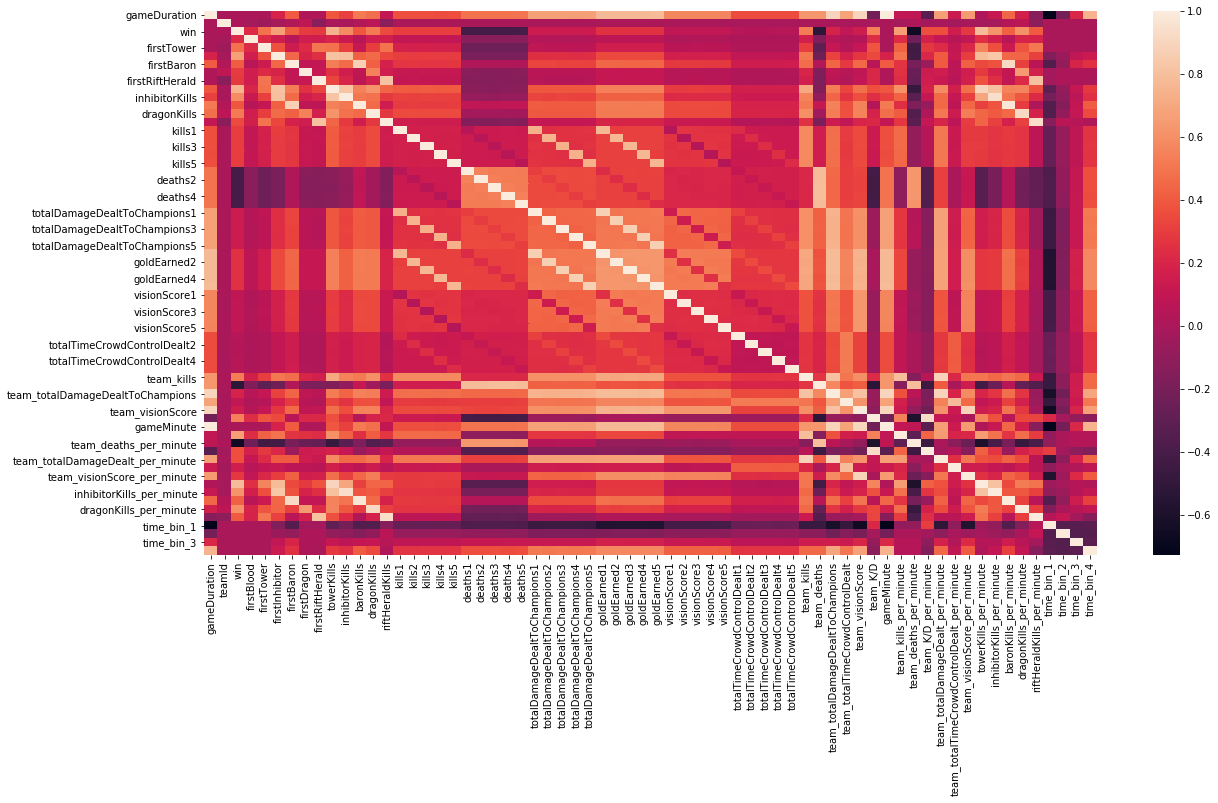

In [27]:
import seaborn as sns    
plt.figure(figsize= (20, 10))
sns.heatmap(gamedata.corr())

개인 기록 칼럼들끼리 선형관계를 띄고 있다. 명백한 다중공선성 문제가 생길 것이라 예상.

In [28]:
personal_col = ['kills1', 'kills2', 'kills3', 'kills4', 'kills5','deaths1', 'deaths2', 'deaths3', 'deaths4', 'deaths5','totalDamageDealtToChampions1', 'totalDamageDealtToChampions2',
       'totalDamageDealtToChampions3', 'totalDamageDealtToChampions4',
       'totalDamageDealtToChampions5','goldEarned1', 'goldEarned2',
       'goldEarned3', 'goldEarned4', 'goldEarned5','visionScore1',
       'visionScore2', 'visionScore3', 'visionScore4', 'visionScore5',
       'totalTimeCrowdControlDealt1', 'totalTimeCrowdControlDealt2',
       'totalTimeCrowdControlDealt3', 'totalTimeCrowdControlDealt4',
       'totalTimeCrowdControlDealt5']

gamedata.drop(personal_col,axis=1,inplace=True)

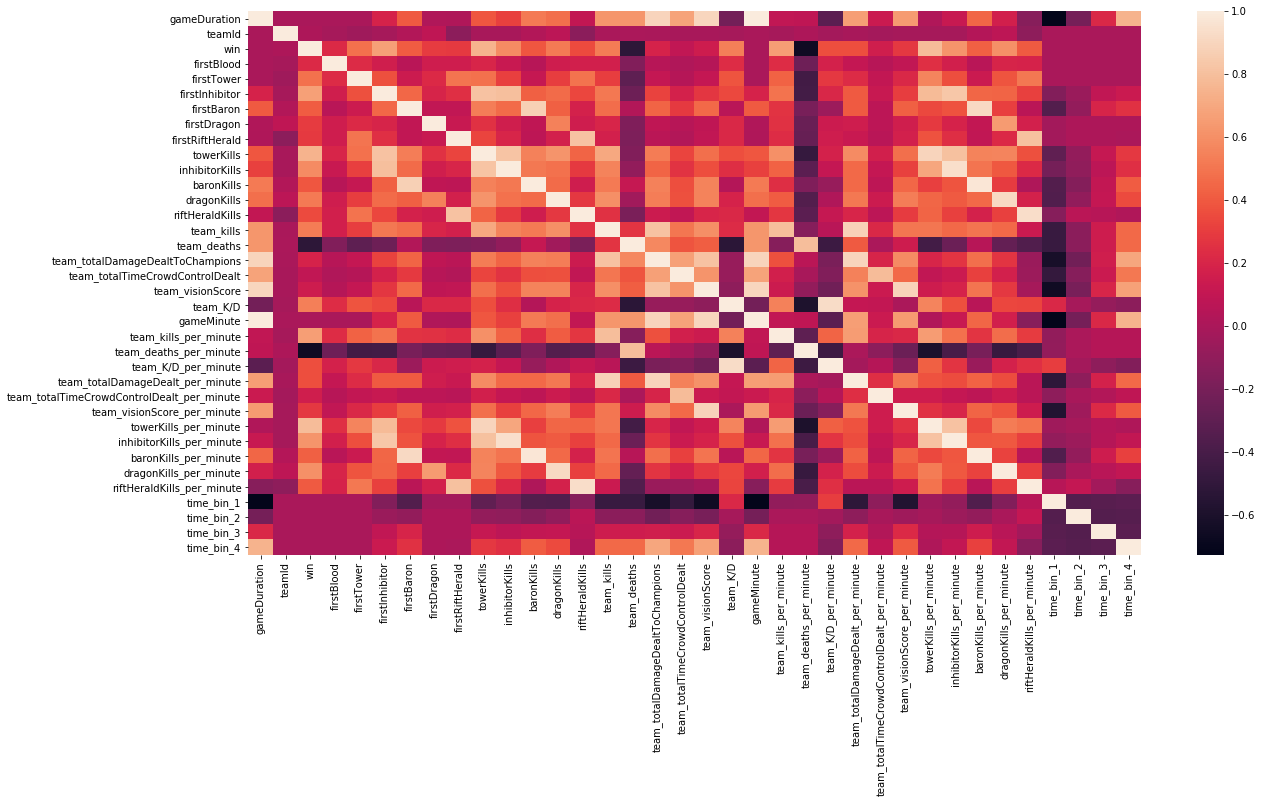

In [29]:
import seaborn as sns    
plt.figure(figsize= (20, 10))
sns.heatmap(gamedata.corr())

팀 종합지표와 분당 팀 성장률이 높은 상관관계를 보이기 때문에 둘 중 하나는 제거해야함.

In [30]:
gamedata.columns

Index(['gameDuration', 'teamId', 'win', 'firstBlood', 'firstTower',
       'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald',
       'towerKills', 'inhibitorKills', 'baronKills', 'dragonKills',
       'riftHeraldKills', 'team_kills', 'team_deaths',
       'team_totalDamageDealtToChampions', 'team_totalTimeCrowdControlDealt',
       'team_visionScore', 'team_K/D', 'gameMinute', 'team_kills_per_minute',
       'team_deaths_per_minute', 'team_K/D_per_minute',
       'team_totalDamageDealt_per_minute',
       'team_totalTimeCrowdControlDealt_per_minute',
       'team_visionScore_per_minute', 'towerKills_per_minute',
       'inhibitorKills_per_minute', 'baronKills_per_minute',
       'dragonKills_per_minute', 'riftHeraldKills_per_minute', 'time_bin_1',
       'time_bin_2', 'time_bin_3', 'time_bin_4'],
      dtype='object')

In [31]:
team_col = ['towerKills','inhibitorKills','baronKills','dragonKills','riftHeraldKills','team_kills', 'team_deaths','team_totalDamageDealtToChampions', 
            'team_totalTimeCrowdControlDealt','team_visionScore','team_K/D']

gamedata.drop(team_col,axis=1,inplace=True)

#오브젝트 갯수를 모두 합한 이 칼럼은 중복적인 요소가 많아 제거
#gamedata.drop("team_object_per_minute",axis=1,inplace=True)

#가설에서 직관적인 지표를 피드백해야 하고, 각 지표가 올라갈수록 골드량이 많아지는 것은 당연하기 때문에 해당 칼럼은 가설을 검정하기에 좋지 않음.
#gamedata.drop("team_goldEarned_per_minute",axis=1,inplace=True)

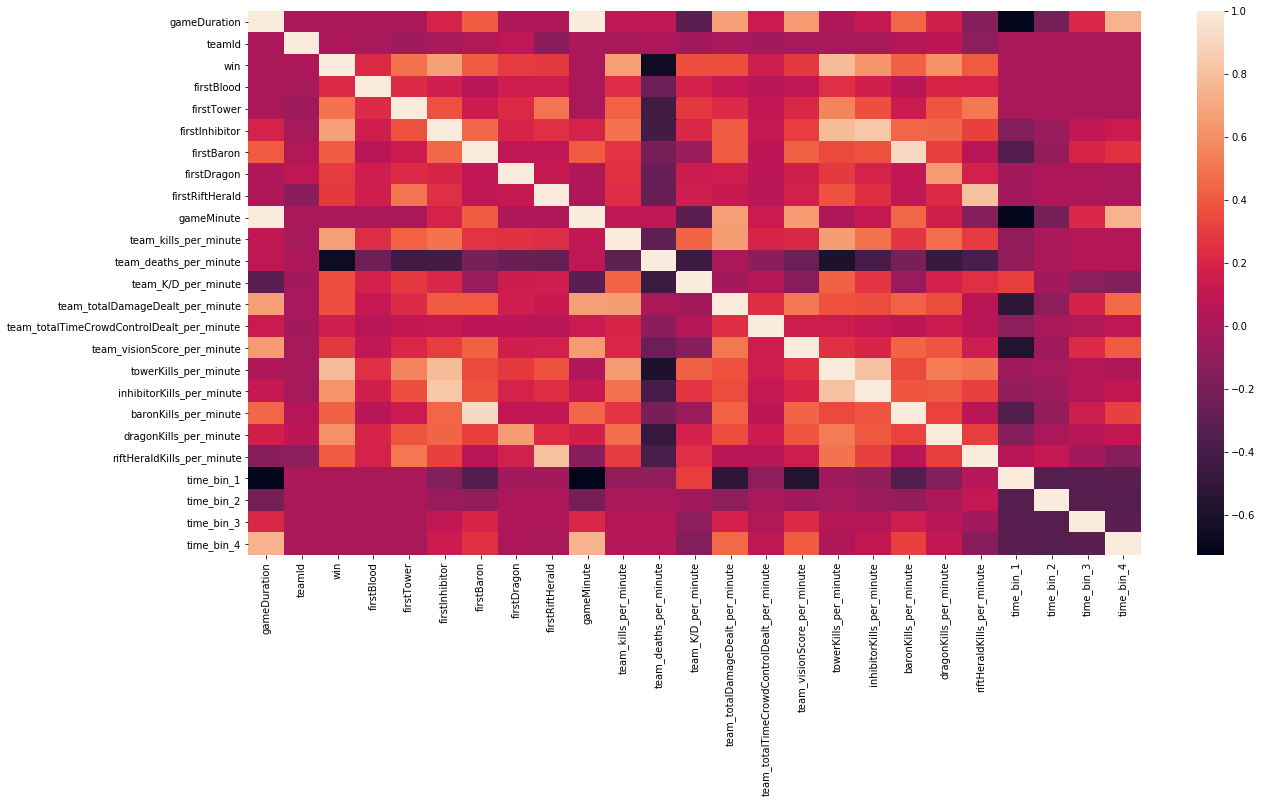

In [32]:
import seaborn as sns    
plt.figure(figsize= (20, 10))
sns.heatmap(gamedata.corr())

독립변수간 상관관계가 많이 제거되었다.

In [33]:
gamedata.drop(["gameDuration","gameMinute"],axis=1,inplace=True)

In [34]:
#승패에 영향이 가는 상관계수 분석
gamedata.corr()["win"].sort_values()

team_deaths_per_minute                       -0.65688
time_bin_3                                   -0.00000
time_bin_4                                   -0.00000
time_bin_2                                   -0.00000
time_bin_1                                    0.00000
teamId                                        0.01238
team_totalTimeCrowdControlDealt_per_minute    0.16229
firstBlood                                    0.21861
team_visionScore_per_minute                   0.28077
firstRiftHerald                               0.28633
firstDragon                                   0.29541
team_K/D_per_minute                           0.36217
team_totalDamageDealt_per_minute              0.36318
riftHeraldKills_per_minute                    0.39976
firstBaron                                    0.40709
baronKills_per_minute                         0.42551
firstTower                                    0.48227
dragonKills_per_minute                        0.60537
inhibitorKills_per_minute   

In [35]:
gamedata

,teamId,win,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,team_kills_per_minute,team_deaths_per_minute,...,team_visionScore_per_minute,towerKills_per_minute,inhibitorKills_per_minute,baronKills_per_minute,dragonKills_per_minute,riftHeraldKills_per_minute,time_bin_1,time_bin_2,time_bin_3,time_bin_4
0,200,1,0,1,1,0,1,1,1.40590,0.68027,...,5.44218,0.40816,0.04535,0.00000,0.13605,0.09070,0,1,0,0
1,100,1,0,0,0,0,1,1,0.86560,0.36446,...,5.69476,0.18223,0.00000,0.00000,0.09112,0.09112,0,1,0,0
2,200,1,1,1,1,0,1,0,1.35048,0.53055,...,5.16077,0.28939,0.04823,0.00000,0.14469,0.04823,0,1,0,0
3,200,1,0,1,0,0,1,1,1.68399,0.81081,...,5.42620,0.18711,0.00000,0.00000,0.06237,0.06237,1,0,0,0
4,200,1,1,1,1,1,0,0,0.91912,0.58824,...,5.66176,0.33088,0.07353,0.03676,0.07353,0.00000,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180923,200,0,0,0,0,0,0,0,0.86514,1.32316,...,4.22392,0.05089,0.00000,0.00000,0.00000,0.00000,1,0,0,0
180924,100,0,0,0,0,0,1,0,0.57007,1.21140,...,5.70071,0.00000,0.00000,0.00000,0.03563,0.00000,0,0,1,0
180925,100,0,1,1,0,0,0,1,0.61475,0.65574,...,5.28689,0.08197,0.00000,0.00000,0.00000,0.04098,0,1,0,0
180926,200,0,1,1,0,0,1,1,1.20425,1.31051,...,6.02125,0.14168,0.00000,0.00000,0.07084,0.03542,0,0,1,0


In [36]:
#VIF 분석으로 최종 검사 , 10 이상일 경우 다중공선성 문제가 생길 수 있음.
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    gamedata.values, i) for i in range(gamedata.shape[1])]
vif["features"] = gamedata.columns
vif

,VIF Factor,features
0,1.03604,teamId
1,4.68537,win
2,1.11186,firstBlood
3,1.80243,firstTower
4,4.22409,firstInhibitor
5,6.79453,firstBaron
6,1.80734,firstDragon
7,3.26748,firstRiftHerald
8,4.52155,team_kills_per_minute
9,2.77898,team_deaths_per_minute


time_bin은 one hot encoding 된 항목으로 서로 상관관계가 있는것이 당연하다. 하지만 전부 나타내는 뜻이 다르므로 그대로 둔다.

# Modeling / 머신러닝 모델 구축

### Logistic Regression 로지스틱 회귀

모델을 구축하기 전, 마지막으로 로지스틱 회귀분석을 시행하여 Input 데이터셋을 분석한다.

In [37]:
gamedata.shape

(178538, 23)

In [38]:
x_data = gamedata.drop("win",axis=1)
y_data = gamedata["win"]

In [39]:
x_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178538 entries, 0 to 180927
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   teamId                                      178538 non-null  int64  
 1   firstBlood                                  178538 non-null  int64  
 2   firstTower                                  178538 non-null  int64  
 3   firstInhibitor                              178538 non-null  int64  
 4   firstBaron                                  178538 non-null  int64  
 5   firstDragon                                 178538 non-null  int64  
 6   firstRiftHerald                             178538 non-null  int64  
 7   team_kills_per_minute                       178538 non-null  float64
 8   team_deaths_per_minute                      178538 non-null  float64
 9   team_K/D_per_minute                         178538 non-null  float64
 

In [40]:
#사용하는 Input column
use_col = list(x_data.columns)
use_col

['teamId',
 'firstBlood',
 'firstTower',
 'firstInhibitor',
 'firstBaron',
 'firstDragon',
 'firstRiftHerald',
 'team_kills_per_minute',
 'team_deaths_per_minute',
 'team_K/D_per_minute',
 'team_totalDamageDealt_per_minute',
 'team_totalTimeCrowdControlDealt_per_minute',
 'team_visionScore_per_minute',
 'towerKills_per_minute',
 'inhibitorKills_per_minute',
 'baronKills_per_minute',
 'dragonKills_per_minute',
 'riftHeraldKills_per_minute',
 'time_bin_1',
 'time_bin_2',
 'time_bin_3',
 'time_bin_4']

In [41]:
import statsmodels.api as sm

logit = sm.Logit(y_data,x_data) #로지스틱 회귀분석 시행
result = logit.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.062058
         Iterations 13


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                        Results: Logit
==============================================================================================
Model:                        Logit                     Pseudo R-squared:          0.910      
Dependent Variable:           win                       AIC:                       22203.5226 
Date:                         2020-05-17 12:25          BIC:                       22425.5589 
No. Observations:             178538                    Log-Likelihood:            -11080.    
Df Model:                     21                        LL-Null:                   -1.2375e+05
Df Residuals:                 178516                    LLR p-value:               0.0000     
Converged:                    1.0000                    Scale:                     1.0000     
No. Iterations:               13.0000                                                         
----------------------------------------------------------------------------------------------
                                            Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
----------------------------------------------------------------------------------------------
teamId                                       0.0011   0.0004   3.1409 0.0017   0.0004   0.0019
firstBlood                                  -0.4533   0.0363 -12.5046 0.0000  -0.5244  -0.3823
firstTower                                  -0.5895   0.0408 -14.4648 0.0000  -0.6694  -0.5097
firstInhibitor                               0.0500   0.0506   0.9884 0.3229  -0.0491   0.1491
firstBaron                                  -0.4725   0.0603  -7.8350 0.0000  -0.5907  -0.3543
firstDragon                                 -0.1393   0.0410  -3.3963 0.0007  -0.2196  -0.0589
firstRiftHerald                              0.3430   0.0588   5.8282 0.0000   0.2276   0.4583
team_kills_per_minute                        5.3903   0.1908  28.2483 0.0000   5.0163   5.7643
team_deaths_per_minute                      -7.9236   0.1858 -42.6492 0.0000  -8.2878  -7.5595
team_K/D_per_minute                         48.1389   3.4781  13.8405 0.0000  41.3219  54.9559
team_totalDamageDealt_per_minute             0.0008   0.0000  17.6971 0.0000   0.0007   0.0009
team_totalTimeCrowdControlDealt_per_minute   0.0061   0.0016   3.8136 0.0001   0.0030   0.0092
team_visionScore_per_minute                 -0.1207   0.0186  -6.4787 0.0000  -0.1572  -0.0842
towerKills_per_minute                       27.1699   0.4417  61.5184 0.0000  26.3042  28.0355
inhibitorKills_per_minute                    8.1186   1.1737   6.9170 0.0000   5.8181  10.4190
baronKills_per_minute                       37.4943   1.5653  23.9531 0.0000  34.4263  40.5622
dragonKills_per_minute                      12.1160   0.6122  19.7908 0.0000  10.9161  13.3159
riftHeraldKills_per_minute                 -15.3500   1.2187 -12.5952 0.0000 -17.7386 -12.9614
time_bin_1                                  -5.2779   0.3022 -17.4671 0.0000  -5.8701  -4.6856
time_bin_2                                  -5.6815   0.2552 -22.2588 0.0000  -6.1817  -5.1812
time_bin_3                                  -6.9378   0.2460 -28.2014 0.0000  -7.4199  -6.4556
time_bin_4                                  -7.3661   0.2380 -30.9504 0.0000  -7.8326  -6.8996
==============================================================================================

"""

모든 변수의 P - Value가 0에 가까우므로 통계적으로 유의미한 변수들이 적합되었고, 아무런 튜닝 없이 단순 로지스틱 회귀로 R-squared(결정계수) 가 0.91에 달함. 

### Logistic Regression Analytics / 로지스틱 회귀 분석

선형회귀는 그대로 회귀계수가 타켓변수에 영향을 미치지만, 로지스틱 회귀는 약간 다르다.

로지스틱 회귀의 오즈는 0일 확률 대비 1일 확률을 나타내므로 회귀계수에 Expotential ^ x 를 적용하면 1이 될 확률에 미치는 영향이 계산된다.

In [42]:
#모든 변수를 하나의 모델에서 해석
for i in range(len(result.params)):
    print('다른 변수가 변하지 않을 때, {} 이 한단위 상승하면 승리할 확률이 {:.5f} 배 증가한다.\n'.format(result.params.keys()[i],np.exp(result.params.values[i])))

다른 변수가 변하지 않을 때, teamId 이 한단위 상승하면 승리할 확률이 1.00114 배 증가한다.

다른 변수가 변하지 않을 때, firstBlood 이 한단위 상승하면 승리할 확률이 0.63550 배 증가한다.

다른 변수가 변하지 않을 때, firstTower 이 한단위 상승하면 승리할 확률이 0.55458 배 증가한다.

다른 변수가 변하지 않을 때, firstInhibitor 이 한단위 상승하면 승리할 확률이 1.05124 배 증가한다.

다른 변수가 변하지 않을 때, firstBaron 이 한단위 상승하면 승리할 확률이 0.62342 배 증가한다.

다른 변수가 변하지 않을 때, firstDragon 이 한단위 상승하면 승리할 확률이 0.87000 배 증가한다.

다른 변수가 변하지 않을 때, firstRiftHerald 이 한단위 상승하면 승리할 확률이 1.40912 배 증가한다.

다른 변수가 변하지 않을 때, team_kills_per_minute 이 한단위 상승하면 승리할 확률이 219.26734 배 증가한다.

다른 변수가 변하지 않을 때, team_deaths_per_minute 이 한단위 상승하면 승리할 확률이 0.00036 배 증가한다.

다른 변수가 변하지 않을 때, team_K/D_per_minute 이 한단위 상승하면 승리할 확률이 806214890534580387840.00000 배 증가한다.

다른 변수가 변하지 않을 때, team_totalDamageDealt_per_minute 이 한단위 상승하면 승리할 확률이 1.00082 배 증가한다.

다른 변수가 변하지 않을 때, team_totalTimeCrowdControlDealt_per_minute 이 한단위 상승하면 승리할 확률이 1.00612 배 증가한다.

다른 변수가 변하지 않을 때, team_visionScore_per_minute 이 한단위 상승하면 승리할 확률이 0.88633 배 증가한다.

다른 변수가 변하지 않을 때, towerKills_per_minut

하지만 데이터들의 스케일이 달라 가중치가 지나치게 크고, 작고 문제가 발생했다.

In [43]:
from sklearn.model_selection import train_test_split

#훈련셋, 테스트셋 계층 샘플링 - 편향 방지
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=7, stratify=y_data) 

## Data Scaling / 데이터 스케일링

데이터의 학습 속도, 모델의 안정성을 증가시킨다.

Scikit-learn이 제공하는 데이터 스케일링 클래스

1. StandardScaler - 채택

평균이 0과 표준편차가 1이 되도록 변환

2. RobustScaler

중앙값(median)이 0, IQR(interquartile range)이 1이 되도록 변환.

3. MinMaxScaler

최대값이 각각 1, 최소값이 0이 되도록 변환

4. MaxAbsScaler

 0을 기준으로 절대값이 가장 큰 수가 1또는 -1이 되도록 변환

In [44]:
#각 feature의 평균을 0, 분산을 1로 변경 - 특성들을 모두 동일한 스케일로 반영

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)
x_train = ss.transform(x_train)
x_test = ss.transform(x_test)

In [45]:
import statsmodels.api as sm

logit = sm.Logit(y_train,x_train) #로지스틱 회귀분석 시행
result = logit.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.064671
         Iterations 11


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.907     
Dependent Variable: win              AIC:              18516.0055
Date:               2020-05-17 12:25 BIC:              18723.2631
No. Observations:   142830           Log-Likelihood:   -9237.0   
Df Model:           20               LL-Null:          -99002.   
Df Residuals:       142809           LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     11.0000                                      
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1        0.0515     0.0199     2.5798   0.0099    0.0124    0.0905
x2       -0.2328     0.0199   -11.6992   0.0000   -0.2718   -0.1938
x3       -0.2519     0.0223   -11.3155   0.0000   -0.2955   -0.2083
x4        0.0273     0.0272     1.0033   0.3157   -0.0260    0.0807
x5       -0.1639     0.0302    -5.4237   0.0000   -0.2232   -0.1047
x6       -0.0584     0.0226    -2.5847   0.0097   -0.1026   -0.0141
x7        0.1510     0.0320     4.7241   0.0000    0.0883    0.2136
x8        3.2122     0.0523    61.4680   0.0000    3.1098    3.3146
x9       -4.3315     0.0530   -81.7102   0.0000   -4.4354   -4.2276
x10      -0.6462     0.0816    -7.9157   0.0000   -0.8063   -0.4862
x11       0.5839     0.0376    15.5470   0.0000    0.5102    0.6575
x12       0.0499     0.0199     2.5084   0.0121    0.0109    0.0888
x13      -0.2382     0.0289    -8.2385   0.0000   -0.2948   -0.1815
x14       3.7375     0.0677    55.2193   0.0000    3.6048    3.8701
x15       0.1510     0.0428     3.5300   0.0004    0.0672    0.2349
x16       0.6571     0.0326    20.1803   0.0000    0.5933    0.7210
x17       0.5533     0.0307    17.9992   0.0000    0.4930    0.6135
x18      -0.4267     0.0400   -10.6567   0.0000   -0.5052   -0.3482
x19       0.6315        nan        nan      nan       nan       nan
x20       0.2507        nan        nan      nan       nan       nan
x21      -0.3315        nan        nan      nan       nan       nan
x22      -0.5688        nan        nan      nan       nan       nan
=================================================================

"""

In [46]:
#모든 변수를 하나의 모델에서 해석
for i in range(len(result.params)):
    print('다른 변수가 변하지 않을 때, {} 이 1 상승하면 승리할 확률이 {:.5f} 배 증가한다.\n'.format(use_col[i],np.exp(result.params.values[i])))

다른 변수가 변하지 않을 때, teamId 이 1 상승하면 승리할 확률이 1.05280 배 증가한다.

다른 변수가 변하지 않을 때, firstBlood 이 1 상승하면 승리할 확률이 0.79228 배 증가한다.

다른 변수가 변하지 않을 때, firstTower 이 1 상승하면 승리할 확률이 0.77733 배 증가한다.

다른 변수가 변하지 않을 때, firstInhibitor 이 1 상승하면 승리할 확률이 1.02769 배 증가한다.

다른 변수가 변하지 않을 때, firstBaron 이 1 상승하면 승리할 확률이 0.84879 배 증가한다.

다른 변수가 변하지 않을 때, firstDragon 이 1 상승하면 승리할 확률이 0.94329 배 증가한다.

다른 변수가 변하지 않을 때, firstRiftHerald 이 1 상승하면 승리할 확률이 1.16297 배 증가한다.

다른 변수가 변하지 않을 때, team_kills_per_minute 이 1 상승하면 승리할 확률이 24.83331 배 증가한다.

다른 변수가 변하지 않을 때, team_deaths_per_minute 이 1 상승하면 승리할 확률이 0.01315 배 증가한다.

다른 변수가 변하지 않을 때, team_K/D_per_minute 이 1 상승하면 승리할 확률이 0.52401 배 증가한다.

다른 변수가 변하지 않을 때, team_totalDamageDealt_per_minute 이 1 상승하면 승리할 확률이 1.79293 배 증가한다.

다른 변수가 변하지 않을 때, team_totalTimeCrowdControlDealt_per_minute 이 1 상승하면 승리할 확률이 1.05113 배 증가한다.

다른 변수가 변하지 않을 때, team_visionScore_per_minute 이 1 상승하면 승리할 확률이 0.78806 배 증가한다.

다른 변수가 변하지 않을 때, towerKills_per_minute 이 1 상승하면 승리할 확률이 41.99089 배 증가한다.

다른 변수가 변하지

특성이 조절되고 이전보다 더 적절한 값이 출력된다. 하지만 아직 특정 칼럼의 가중치가 조금 높으므로 규제를 추가한다.

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [48]:
%%time
#그리드 서치로 하이퍼파라미터 튜닝, 계층별 10차 교차 검증 수행
param_grid = {"C" : [0.001,0.01,0.1,1,10,10,100]} #규제의 강도만 조절하고, 방식은 바꾸지 않는다. 조금이라도 승패에 영향이 가는 변수를 모두 반영하기 위해 L2(릿지)norm을 적용.
grid_search = GridSearchCV(LogisticRegression(),param_grid,cv=10,return_train_score=True,n_jobs=-1)

grid_search.fit(x_train,y_train)

CPU times: user 2.3 s, sys: 343 ms, total: 2.64 s
Wall time: 38.1 s


GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [49]:
coef = pd.DataFrame(data={"coef":grid_search.best_estimator_.coef_.tolist()[0],"col":use_col})
coef

,coef,col
0,0.05089,teamId
1,-0.22097,firstBlood
2,-0.29619,firstTower
3,0.02066,firstInhibitor
4,-0.18304,firstBaron
5,-0.06311,firstDragon
6,0.17474,firstRiftHerald
7,2.26493,team_kills_per_minute
8,-3.27822,team_deaths_per_minute
9,4.72528,team_K/D_per_minute


In [50]:
for i in range(len(coef)):
    print('다른 변수가 변하지 않을 때, {} 이 1 상승하면 승리할 확률이 {:.5f} 배 증가한다.\n'.format(use_col[i],np.exp(coef.iloc[i,0])))

다른 변수가 변하지 않을 때, teamId 이 1 상승하면 승리할 확률이 1.05220 배 증가한다.

다른 변수가 변하지 않을 때, firstBlood 이 1 상승하면 승리할 확률이 0.80174 배 증가한다.

다른 변수가 변하지 않을 때, firstTower 이 1 상승하면 승리할 확률이 0.74365 배 증가한다.

다른 변수가 변하지 않을 때, firstInhibitor 이 1 상승하면 승리할 확률이 1.02088 배 증가한다.

다른 변수가 변하지 않을 때, firstBaron 이 1 상승하면 승리할 확률이 0.83273 배 증가한다.

다른 변수가 변하지 않을 때, firstDragon 이 1 상승하면 승리할 확률이 0.93884 배 증가한다.

다른 변수가 변하지 않을 때, firstRiftHerald 이 1 상승하면 승리할 확률이 1.19094 배 증가한다.

다른 변수가 변하지 않을 때, team_kills_per_minute 이 1 상승하면 승리할 확률이 9.63046 배 증가한다.

다른 변수가 변하지 않을 때, team_deaths_per_minute 이 1 상승하면 승리할 확률이 0.03770 배 증가한다.

다른 변수가 변하지 않을 때, team_K/D_per_minute 이 1 상승하면 승리할 확률이 112.76167 배 증가한다.

다른 변수가 변하지 않을 때, team_totalDamageDealt_per_minute 이 1 상승하면 승리할 확률이 1.84410 배 증가한다.

다른 변수가 변하지 않을 때, team_totalTimeCrowdControlDealt_per_minute 이 1 상승하면 승리할 확률이 1.07194 배 증가한다.

다른 변수가 변하지 않을 때, team_visionScore_per_minute 이 1 상승하면 승리할 확률이 0.82380 배 증가한다.

다른 변수가 변하지 않을 때, towerKills_per_minute 이 1 상승하면 승리할 확률이 51.40136 배 증가한다.

다른 변수가 변하

K/D와 towerKill은 게임 구조상 분당 1개씩 증가할 수 없는 수치이지만, 만약 가능하다면 승리 확률이 어마어마하게 올라간다.
time_bin을 보면 예상대로 시간이 갈수록 승리에 미치는 영향이 줄어든다는 것을 알 수 있다.

하지만 로지스틱 회귀는 공선성 영향을 크게 받기 때문에(중요한 칼럼만 가중치가 커짐) 해당 회귀 분석결과를 그대로 신뢰할 수는 없다.
또한 로지스틱 회귀는 안좋게 될 확률(0이 될 확률)을 모르기 때문에 패배 확률 자체가 낮다면 의미가 없다.

In [51]:
print("최적 파라미터 : {}".format(grid_search.best_params_))

print("훈련세트 정확도(교차 검증 정확도 평균) : {}".format(grid_search.best_score_))

print(grid_search.best_estimator_)

최적 파라미터 : {'C': 1}
훈련세트 정확도(교차 검증 정확도 평균) : 0.976720576909613
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [52]:
#결과표시
np.set_printoptions(suppress=True)

pred_y_test = grid_search.predict(x_test)
proba_y_test = grid_search.predict_proba(x_test)
display(pred_y_test,proba_y_test)

array([1, 0, 1, ..., 1, 1, 0])

array([[0.00006166, 0.99993834],
       [0.72050702, 0.27949298],
       [0.        , 1.        ],
       ...,
       [0.4527523 , 0.5472477 ],
       [0.0003097 , 0.9996903 ],
       [0.99997622, 0.00002378]])

In [53]:
print("테스트세트 정확도 : {}".format(grid_search.score(x_test,y_test)))
log_cls_score = grid_search.score(x_test,y_test)

테스트세트 정확도 : 0.9767279041111235


In [54]:
#f1 스코어
from sklearn.metrics import f1_score
score = f1_score(y_test,pred_y_test)
print("테스트세트 f1 점수 : {}".format(score))

테스트세트 f1 점수 : 0.9767649937089332


단순한 로지스틱 회귀에 스케일링, 규제, 교차검증을 적용한 모델의 테스트세트 정확도는 97.6%에 달한다.

## Model Selection /  모델 선택

로지스틱 이외에도 이진 분류에 적합한 많은 모델들이 있는데, 그 중에 몇가지를 선정하여 실험

모델의 평가 지표는 Accuracy(정확도) 로 타켓 클래스가 균형을 이루고 있기 때문.

> 선정한 모델

* Random Forest 랜덤 포레스트

단일 결정 트리의 단점을 보완하고, 매개변수 튜닝 없이도 강력한 성능을 보이는 모델이며, 특성 중요도를 제공하여 채택.

* Catboost 캣 부스트

데이터셋의 절반은 카테고리형으로 구성되어 있고, 그래디언트 부스팅 모델 중 매개변수 튜닝 없이도 강력한 성능을 보이는 모델이므로 채택.

* XGBoost Extream Gradient boosting

기존 그래디언트 부스팅 모델의 단점을 보완하고 빠른 학습을 한다. 매개변수에 민감하지만 GPU 병렬연산을 이용한 그리드 서치를 지원하여 채택.

============================================================================================================================

> 고려한 모델

* KNN 최근접 이웃 알고리즘

해당 데이터셋에서 이웃간 거리를 이용한 분류가 어렵고, 데이터셋이 크고 적절한 이웃 갯수를 찾는 것이 어려우므로 기각.

* SVM 서포트 벡터 머신

고차원의 해당 데이터셋에서 잘 맞을거라 생각하지만, 분석이 어려워서 기각.

* Naive bayes 나이브 베이즈

선형 모델보다 빠른 학습이 가능하고 대용량, 고차원 데이터에 적합하지만 모든 특징들이 동등하고 독립적이라 가정하는 모델이라 어느정도 독립변수간 상관관계가 존재하는 경기기록에는 맞지 않을거라 생각.

* LightGBM

기존 그래디언트 부스팅 모델의 단점을 보완하고 빠른 학습을 하지만, 매개변수 튜닝 시, XGBoost가 상대적으로 좋은 결과를 가져와서 기각.

* Neural Network / Deep Learning 신경망 / 딥러닝

매우 복잡한 모델을 설계할 수 있고 대용량, 고차원 데이터에 적합하지만 SWM과 마찬가지로 하이퍼 파라미터 튜닝이 복잡함.

In [55]:
#실제 모델들과 비교하기 위한 무작위 랜덤모델
from sklearn.dummy import DummyClassifier
dm = DummyClassifier(strategy="stratified").fit(x_train,y_train)
dm.score(x_test,y_test)

0.4996359359247228

랜덤선택모델은 0.49 ~0.5 의 정확도를 보이므로, 데이터에 불균형이 존재하지 않음.

### Random Forest Classifier/ 랜덤 포레스트 분류기 (결정 트리 앙상블)

In [56]:
# %%time
# from sklearn.ensemble import RandomForestClassifier
# #그리드 서치로 하이퍼파라미터 튜닝, 계층별 5차 교차 검증 수행
# param_grid = {"n_estimators" : [10,50,100,500],
#              "criterion": ["entropy","gini"]}

# rf = RandomForestClassifier(random_state=7,n_jobs=-1)
# grid_search = GridSearchCV(rf,param_grid,cv=5,return_train_score=True)

# grid_search.fit(x_train,y_train)

# print("최적 파라미터 : {}".format(grid_search.best_params_))

# print("훈련세트 정확도(교차 검증 정확도 평균) : {}".format(grid_search.best_score_))

# print(grid_search.best_estimator_)

# print("테스트세트 정확도 : {}".format(grid_search.score(x_test,y_test)))
# rf_cls_score = grid_search.score(x_test,y_test)

# result = pd.DataFrame(grid_search.cv_results_)
# result

#최적 파라미터 : {'criterion': 'entropy', 'n_estimators': 100}
#훈련세트 정확도(교차 검증 정확도 평균) : 0.9791780438283274

In [57]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100,criterion="entropy",random_state=7,n_jobs=-1)
rf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [58]:
print("훈련세트 정확도 : {}".format(rf.score(x_train,y_train)))

print("테스트세트 정확도 : {}".format(rf.score(x_test,y_test)))

훈련세트 정확도 : 0.9999859973394946
테스트세트 정확도 : 0.9784642097009073


Random Forest에 파라미터 튜닝을 적용한 모델은 정확도는 97.8에 달함.

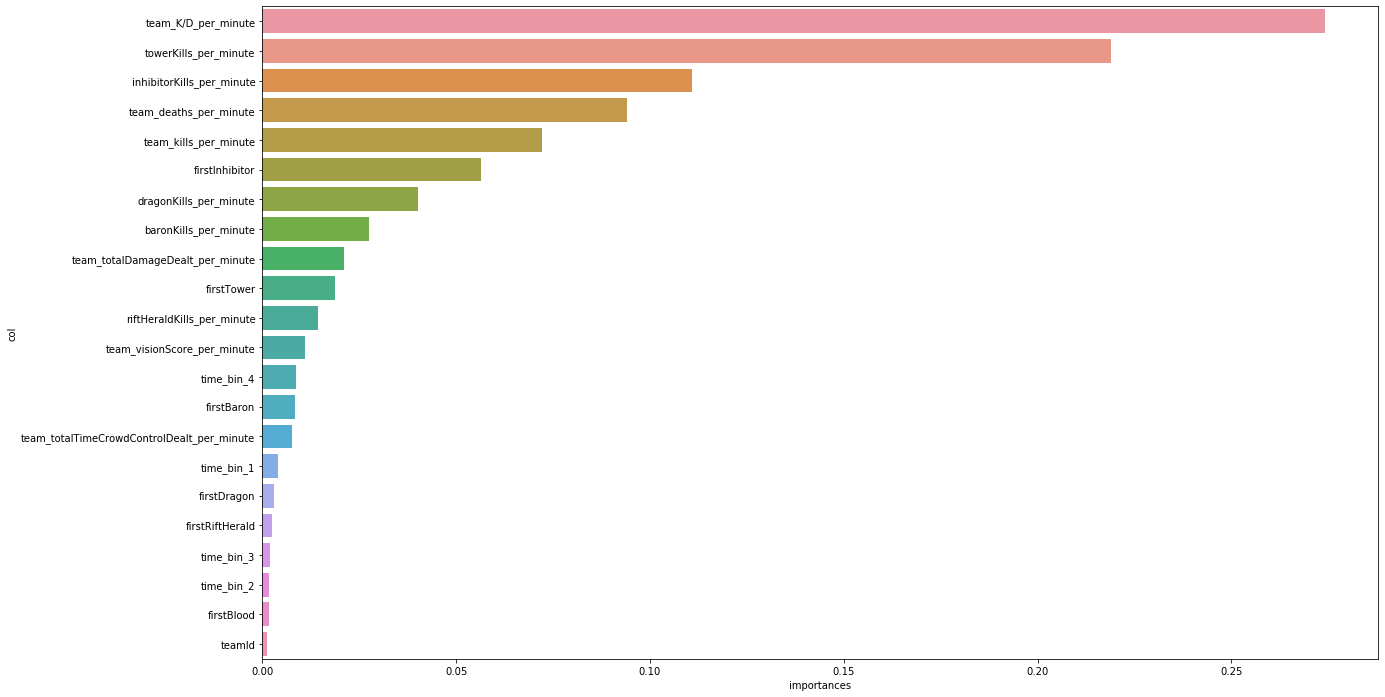

In [59]:
#특성 중요도 분석
import seaborn as sns

plt.figure(figsize=(20,12))
feat_imp = {'col' : x_data.columns,
            'importances' : rf.feature_importances_}

feat_imp = pd.DataFrame(feat_imp).sort_values(by = 'importances', ascending = False)

sns.barplot(y = feat_imp['col'] ,
            x = feat_imp['importances'])

로지스틱 회귀와 마찬가지로 게임의 승패를 판가름하는 중요한 요소는 분당 팀의 K/D, 분당 팀의 타워 파괴량으로 나타났다.(롤은 타워를 부숴야 이길 수 있는 게임이므로)

회귀분석에서 잡아내지 못했던 것은, 분당 킬보다 분당 데스가 더 중요하게 나타났다. 이는 모델이 해석한 결과, 킬을 많이하는 것보다는 데스를 적게하는것이 중요하다는 것이다.

또한 EDA에서 분석한대로 대부분의 first(선취) 관련 칼럼들은 중요도가 낮은 반면, first_inhibitor은 킬데스 다음으로 중요하다고 한다. 이는 게임시에 목표 오브젝트는 억제기가 최우선이다, 라는 통찰을 제공한다.



### Catboost / 카테고리 부스트 (그라디언트 부스팅)

catboost 모델은 xgboost,lgbm 과 달리 트리의 다형성과 오버피팅 문제를 내부 알고리즘이 자체적으로 지원하여 파라미터 튜닝이 크게 필요없음.

In [60]:
from catboost import CatBoostClassifier

cbr = CatBoostClassifier(verbose=50,task_type="GPU")
cbr.fit(x_train,y_train)

Learning rate set to 0.02566
0:	learn: 0.6198740	total: 20.8ms	remaining: 20.8s
50:	learn: 0.0749130	total: 427ms	remaining: 7.94s
100:	learn: 0.0611174	total: 854ms	remaining: 7.6s
150:	learn: 0.0570223	total: 1.38s	remaining: 7.77s
200:	learn: 0.0545833	total: 1.79s	remaining: 7.12s
250:	learn: 0.0530746	total: 2.25s	remaining: 6.73s
300:	learn: 0.0519323	total: 2.74s	remaining: 6.37s
350:	learn: 0.0510225	total: 3.24s	remaining: 5.98s
400:	learn: 0.0502327	total: 3.65s	remaining: 5.45s
450:	learn: 0.0495356	total: 4.04s	remaining: 4.92s
500:	learn: 0.0489017	total: 4.44s	remaining: 4.42s
550:	learn: 0.0482941	total: 4.82s	remaining: 3.93s
600:	learn: 0.0477394	total: 5.21s	remaining: 3.46s
650:	learn: 0.0472663	total: 5.61s	remaining: 3.01s
700:	learn: 0.0467756	total: 6s	remaining: 2.56s
750:	learn: 0.0462865	total: 6.41s	remaining: 2.13s
800:	learn: 0.0458887	total: 6.82s	remaining: 1.7s
850:	learn: 0.0454801	total: 7.24s	remaining: 1.27s
900:	learn: 0.0450709	total: 7.63s	remaini

In [61]:
print("훈련세트 정확도 : {}".format(cbr.score(x_train,y_train)))

print("테스트세트 정확도 : {}".format(cbr.score(x_test,y_test)))

훈련세트 정확도 : 0.9833858433102289
테스트세트 정확도 : 0.9800884955752213


튜닝을 하지 않았지만, 기본 옵션의 GPU Catboost 정확도는 97.9 - 98.0 %에 달한다.

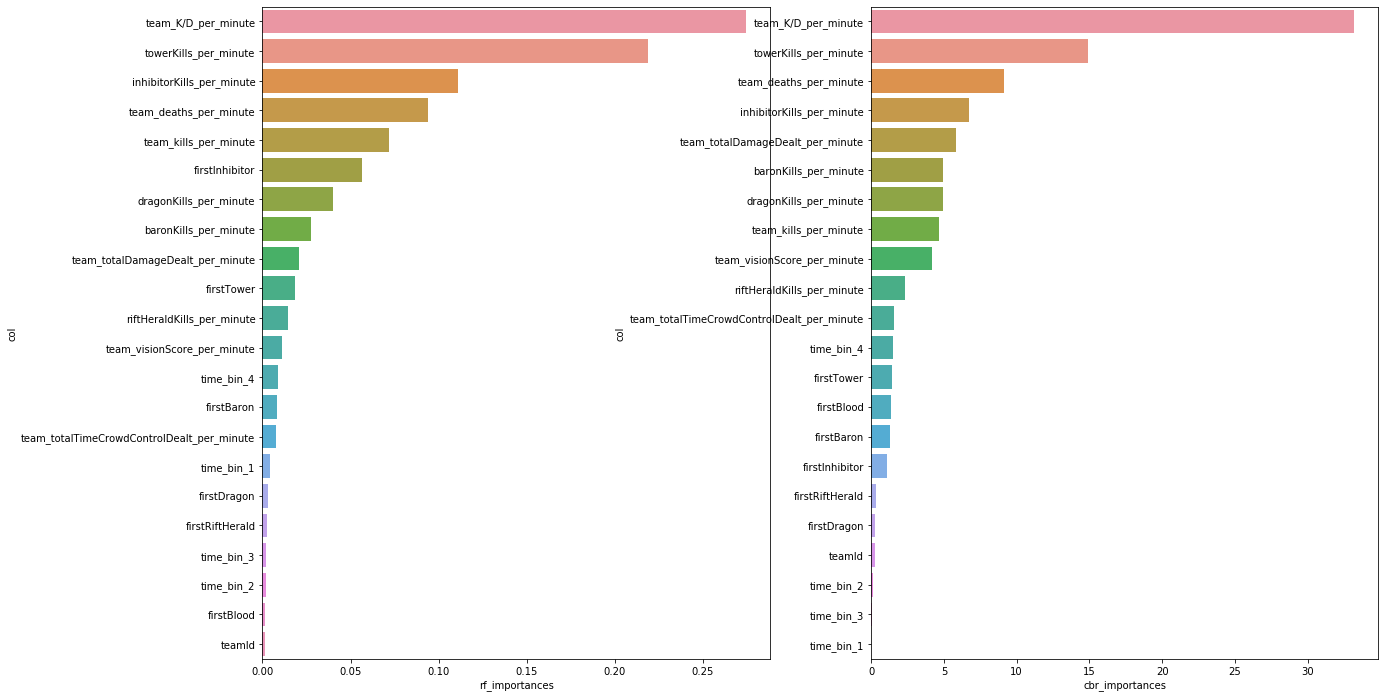

In [62]:
#특성 중요도 분석
import seaborn as sns

f,ax = plt.subplots(1,2,figsize=(20,12))
rf_imp = {'col' : x_data.columns,
            'rf_importances' : rf.feature_importances_}

rf_imp = pd.DataFrame(rf_imp).sort_values(by = 'rf_importances', ascending = False)

sns.barplot(y = rf_imp['col'] ,
            x = rf_imp['rf_importances'],ax=ax[0])

cbr_imp = {'col' : x_data.columns,
            'cbr_importances' : cbr.feature_importances_}

cbr_imp = pd.DataFrame(cbr_imp).sort_values(by = 'cbr_importances', ascending = False)

sns.barplot(y = cbr_imp['col'] ,
            x = cbr_imp['cbr_importances'],ax=ax[1])

캣부스트 모델에서는 랜덤포레스트보다, 데스를 더 중요시하고, 팀의 총데미지의 중요도가 훨씬 높아졋다. 또한 오브젝트들의 칼럼 중요도가 팀의 기록보다 더 중요한 형태로 바뀌었다.

이는 카테고리 칼럼을 잘 처리하는 캣포레스트 특성이 반영되어, 카테고리적인 느낌을 띄는 오브젝트 킬 칼럼들의 중요도가 높아진 것으로 보인다.

### XGBoost / Extreme Gradient Boosting (그라디언트 부스팅)

In [63]:
# from xgboost import XGBClassifier

# xgb = XGBClassifier()

# param_grid = {'objective':['binary:logistic'],
#               'learning_rate': [0.025], #catboost에서 측정된 적절 eta
#               'max_depth': [2,3,5],
#               'min_child_weight': [1,5,10], #최소 가중치 합 : 높게하면 언더피팅
#               'colsample_bytree': [0.7],
#               'n_estimators': [10,50,100,1000],
#               'seed': [7]}

# grid_search = GridSearchCV(xgb, param_grid, n_jobs=-1, 
#                    cv=5, 
#                    verbose=2, refit=True)

# grid_search.fit(x_train, y_train)

#최적 파라미터 : {'objective':['binary:logistic'],
#               'learning_rate': [0.025], #catboost에서 측정된 적절 eta
#               'max_depth': [3],
#               'min_child_weight': [10], #최소 가중치 합 : 높게하면 언더피팅
#               'colsample_bytree': [0.7],
#               'n_estimators': [1000],
#               'seed': [7]}
#훈련세트 정확도(교차 검증 정확도 평균) : 0.9795003920690042

In [64]:
from xgboost import XGBClassifier
xgb = XGBClassifier(
    objective='binary:logistic',
    max_depth=3,
    n_estimators=1000,
    min_child_weight=10, 
    colsample_bytree=0.7, 
    eta=0.025,
    nthread=-1,
    seed=7)

xgb.fit(x_train, y_train, verbose=True)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eta=0.025, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.0250000004, max_delta_step=0, max_depth=3,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=7, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=7, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [65]:
print("훈련세트 정확도 : {}".format(xgb.score(x_train,y_train)))

print("테스트세트 정확도 : {}".format(xgb.score(x_test,y_test)))

훈련세트 정확도 : 0.9815164881327452
테스트세트 정확도 : 0.9795003920690042


In [66]:
xgb.feature_importances_

array([0.00046764, 0.00265302, 0.00475189, 0.04080131, 0.00429735,
       0.00113939, 0.00112001, 0.05679017, 0.03778691, 0.34426668,
       0.00563955, 0.00090821, 0.00236516, 0.12414122, 0.12997055,
       0.01606116, 0.01259789, 0.00495214, 0.09050476, 0.00186963,
       0.00173922, 0.11517613], dtype=float32)

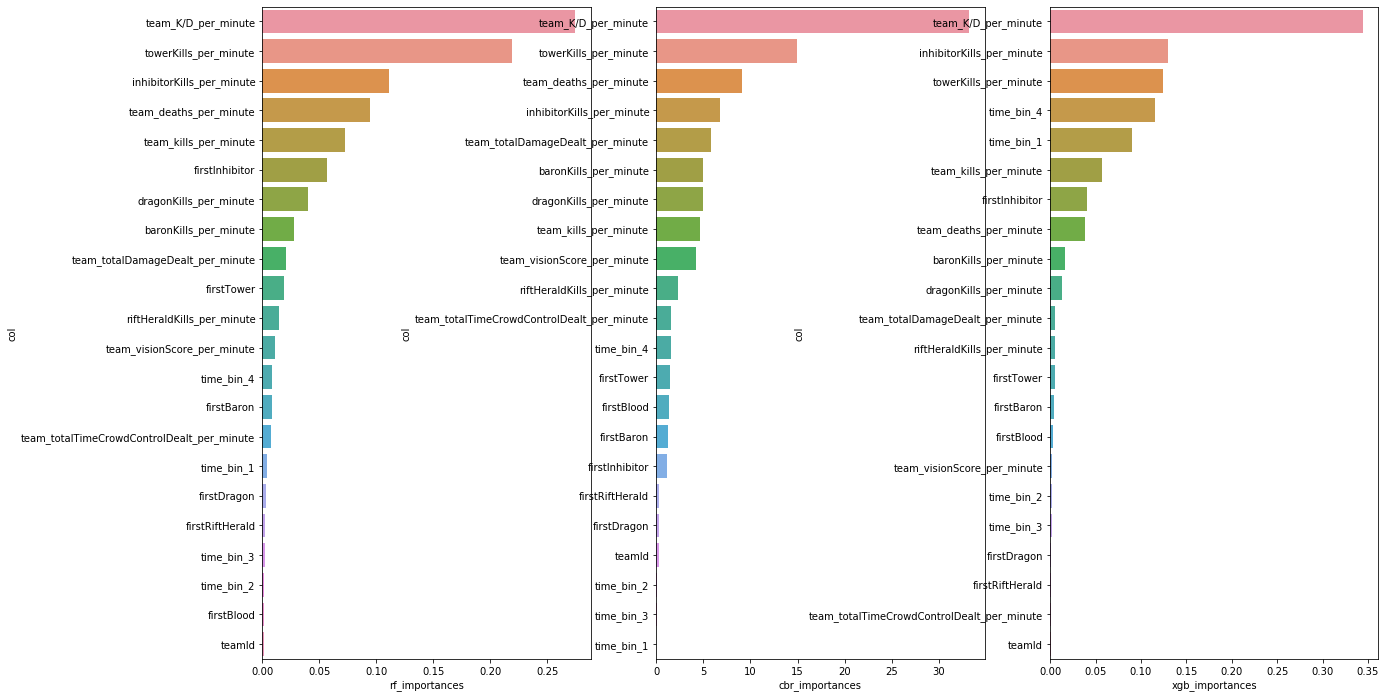

In [67]:
#특성 중요도 분석
import seaborn as sns

f,ax = plt.subplots(1,3,figsize=(20,12))
rf_imp = {'col' : x_data.columns,
            'rf_importances' : rf.feature_importances_}

rf_imp = pd.DataFrame(rf_imp).sort_values(by = 'rf_importances', ascending = False)

sns.barplot(y = rf_imp['col'] ,
            x = rf_imp['rf_importances'],ax=ax[0])

cbr_imp = {'col' : x_data.columns,
            'cbr_importances' : cbr.feature_importances_}

cbr_imp = pd.DataFrame(cbr_imp).sort_values(by = 'cbr_importances', ascending = False)

sns.barplot(y = cbr_imp['col'] ,
            x = cbr_imp['cbr_importances'],ax=ax[1])

xgb_imp = {'col' : x_data.columns,
            'xgb_importances' : xgb.feature_importances_}

xgb_imp = pd.DataFrame(xgb_imp).sort_values(by = 'xgb_importances', ascending = False)

sns.barplot(y = xgb_imp['col'] ,
            x = xgb_imp['xgb_importances'],ax=ax[2])

흥미로운 결과가 나타났다. XGB 모델은 time_bin의 중요도가 대폭 상승했는데, 그 중에서도 20분이내, 30분이후를 나타내는 지표가 대폭 상승했다. 

시간대 앞에 inhibitorKills와 tower킬이 있는 것을 봐선, 시계열적인 학습을 한게 아닐까 추측된다.

뿐만 아니라, 다른 모델들에서도 time_bin_4가 어느정도의 중요성을 띄는 것이 보이는데 EDA와 회귀분석에서 추측한 결과로는, 게임시간이 길어질수록 승패가 불투명해질거라 생각했는데

모델들이 해석한 결과는 게임시간이 길어질수록 승패가 명확해진다는 것을 의미한다.

XGB모델은 그 중에서도 k/d 가 높고, 억제기 파괴량이 높고, 포탑 파괴량이 높을때, 시간대가 30분 이후나, 20분 이전이라면 승패가 명확하다는 것을 학습한 것 같다.

### Model Save & Load

앞으로 실제 데이터의 예측에 있어선 time_bin_4, time_bin_1일때에 대해서 XGB모델을 적용하고, time_bin_2,time_3 일때 전체적인 예측력이 높은 Catboost 모델을 사용할 것이다.

In [68]:
cbr.save_model("LOL_predict_cbr.cbm")

In [69]:
xgb.save_model("LOL_predict_xgb.bst")

In [70]:
cbr = CatBoostClassifier()
cbr.load_model("LOL_predict_cbr.cbm")

In [71]:
xgb = XGBClassifier({'nthread': 4})
xgb.load_model('LOL_predict_xgb.bst')